<table class="ee-notebook-buttons" align="center">
    <td><a target="_blank"  href="https://colab.research.google.com/github/yotarazona/scikit-eo/blob/main/examples/notebooks/17_Deep_Learning_Burned_area_Segmentation_UsingRadar.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a></td>
</table>

# **_<div class="alert alert-success"><font color='darkred'> Tutorials: 17 Burned Area Mapping using Deep Learning</font></div>_**

# 1.0 Libraries

To install ```scikit-eo``` you can do it with the following line:

In [1]:
!pip install rasterio scikeo gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 1.8 MB/s eta 0:00:00


Libraries to be used:

In [2]:
import rasterio
import numpy as np
from scikeo.deeplearning import processing, trainUnet, predictRaster
from scikeo.deeplearning import evaluateSegmentation
from scikeo.plot import plotRGB
import matplotlib.pyplot as plt
import matplotlib as mpl

Connecting to Google Drive

In [3]:
# Connect to Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Reading dataset directly from the external server (Google Drive in this case). To do this, ```gdown``` and ```zipfile``` will be installed before. Then you will only need to run the following line:

In [10]:
import gdown, zipfile

# Google Drive direct link
file_id = "1vN9Wzcdn2_sLcwNPrLyJ2M6iH7hiW0i7"
url = f"https://drive.google.com/uc?id={file_id}"

# Define path in Drive
output_path = "/content/drive/MyDrive/11_deepLearning.zip"

# Download from Google Drive link
gdown.download(url, output_path, quiet=False)

# Extract inside your Drive
with zipfile.ZipFile(output_path, "r") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive")

Downloading...
From (original): https://drive.google.com/uc?id=1vN9Wzcdn2_sLcwNPrLyJ2M6iH7hiW0i7
From (redirected): https://drive.google.com/uc?id=1vN9Wzcdn2_sLcwNPrLyJ2M6iH7hiW0i7&confirm=t&uuid=cbf035e4-6204-4867-9354-dd21e22fdb79
To: /content/drive/MyDrive/11_deepLearning.zip
100%|██████████| 2.32G/2.32G [00:10<00:00, 230MB/s]


## 2.0 Satellite images

Sentinel-1 C-band will be used to classify burned and unburned areas using Deep Learning. This image contains two polarizations VV and VH which will be use to compute the Normalized Radar Burn Ratio (NRBR) ([Tarazona et al., 2025](https://ieeexplore.ieee.org/document/11096539)).

Classes to be mapped are:
- Unburned (pixel value 0)
- Burned (pixel value 1)

In [11]:
data_dir = "/content/drive/MyDrive/11_deepLearning/"

## satellite image (NRBR)
## TRAINING/VALIDATION
# Til30
path_raster_img = data_dir + "NRBR_Tile30.tif"
img_training = rasterio.open(path_raster_img)
# reference data
path_raster_label = data_dir + "Label_Tile30.tif"
label = rasterio.open(path_raster_label)

## TESTING
# Tile29 for testing
path_raster_img_test = data_dir + "NRBR_Tile29.tif"
img_test = rasterio.open(path_raster_img_test)

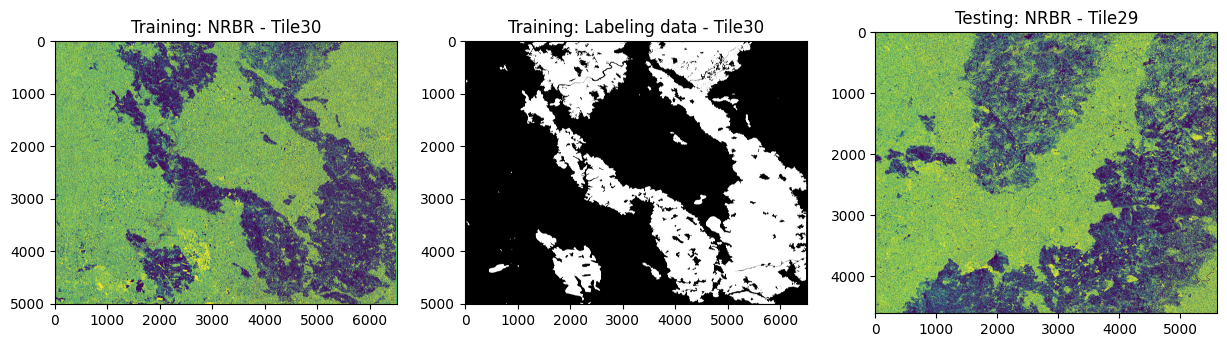

In [12]:
orig_map = plt.colormaps['Greys']
reversed_map = orig_map.reversed()

def preprocess_band(arr, pmin=15, pmax=85):
    """Replace NaN with zero and apply histogram stretch by percentiles."""
    # Replace NaN with 0
    arr = np.nan_to_num(arr, nan=0)
    # Apply histogram stretch
    low, high = np.nanpercentile(arr, pmin), np.nanpercentile(arr, pmax)
    arr = np.clip(arr, low, high)
    arr = (arr - low) / (high - low + 1e-6)  # normalize 0–1
    return arr.astype(np.float32)

img_training = preprocess_band(img_training.read(1))
label = label.read(1); label[np.isnan(label)] = 0
img_test = preprocess_band(img_test.read(1))

fig, ax = plt.subplots(1, 3, figsize = (15,9))
ax[0].imshow(img_training)
ax[0].set_title('Training: NRBR - Tile30')
ax[1].imshow(label, cmap = reversed_map)
ax[1].set_title('Training: Labeling data - Tile30')
ax[2].imshow(img_test)
ax[2].set_title('Testing: NRBR - Tile29')
plt.show()

## 3.0 Burned area mapping

**Processing patches for training/validation**:

In this step, patches (NRBR and Reference data patches) will be generated with the ```processing()``` function. Key arguments are
- ```patch_size```: Por example, size of 128, 64, etc.
- ```export_patches```: If True, NRBR patches will be exported in your local disc.
- ```export_labels```: If True, Reference data patches will be exported in your local disc.
- ```overlap```: Put a number if you wan to export overlaped patches.

In [13]:
# Step 1
X_patches, y_patches = processing(raster_path = path_raster_img,
                                  label_path = path_raster_label,
                                  patch_size = 256,
                                  export_patches = False,
                                  output_dir = None,
                                  export_labels = False,
                                  labels_output_dir = None,
                                  padding_mode = 'constant',
                                  padding_value = 0,
                                  overlap = 0)

In [14]:
# print basic details
print('Input features (NRBR) shape:', X_patches.shape)
print('\nInput labels shape:', y_patches.shape)

Input features (NRBR) shape: (520, 256, 256, 1)

Input labels shape: (520, 256, 256, 1)


When you print the dimensions of the tensors, you will see:  

- `X_patches` has shape **(N, R, C, B)**, where:  
  - **N** = number of generated patches  
  - **R** = number of rows per patch  
  - **C** = number of columns per patch  
  - **B** = number of spectral bands (channels)  

- `y_patches` has shape **(N, R, C, 1)**, where the last dimension is always **1**, representing the label or class channel for each pixel in the patch.

**Preprocessing:**

Before model training, the input patches were standardized using scikit-learn's ```StandardScaler()```, which applies Z-score normalization by centering the data (subtracting the mean) and scaling it by the standard deviation. This preprocessing step improves training stability and ensures better generalization across different geographic tiles.

**U-net architecture:**

U-Net is a convolutional neural network architecture widely used for satellite image segmentation because of its ability to capture both spatial context and fine details. It follows an encoder–decoder structure: the encoder progressively downsamples the input to learn high-level features, while the decoder upsamples to reconstruct spatial resolution. Skip connections between corresponding encoder and decoder layers help preserve important spatial information, enabling precise boundary detection. This combination makes U-Net particularly effective for tasks like land cover classification, building extraction, and other remote sensing applications.

<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2023/11/image-30.png" align="center" width="600"/>

In this step, the U-Net model will be trained with the ```trainUnet()``` function. Key arguments are:

- ```X_train```: Training image patches (X_patches).  
- ```y_train```: Training label patches (y_patches).  
- ```input_shape```: Shape of the input patches, e.g., (128, 128, 1) for single-band or (128, 128, 3) for RGB.  
- ```num_classes```: Number of classes (1 for binary segmentation (e.g., burned and unburned), n for multiclass).  
- ```normalize```: If `True`, applies normalization (StandardScaler) band by band.  
- ```dropout_rate```: Dropout probability for regularization (e.g., 0.2).  
- ```learning_rate```: Learning rate for the optimizer (e.g., 1e-3).  
- ```batch_size```: Number of patches per training batch.  
- ```epochs```: Number of training epochs.  
- ```validation_split```: Fraction of the data to use for validation (e.g., 0.1 for 10%).  
- ```data_augumentation```: If True, applies random flips and rotations for augmentation (default=False).
- ```validation_data```: Alternatively, provide a custom validation dataset instead of splitting.  
- ```save_best_model```: If `True`, saves the model with the best validation IoU score.  
- ```model_path```: File path where the best model will be saved (e.g., "/data/best_model.keras"), if not, put `None`

In [ ]:
# Step 2: train with preprocessing
model, history = trainUnet(
    X_train=X_patches,
    y_train=y_patches,
    input_shape=(256, 256, 1),  # Depends on the number of bands
    num_classes=1,  # 1 for binary (burned and unburned), n for multiclass
    normalize=True,  # Normalize with StandardScaler
    dropout_rate=0.2,
    learning_rate=1e-3,
    batch_size=32,
    epochs=100,
    validation_split=0.3,   # use 10% (0.1) of the data for validation
    data_augmentation = False,
    save_best_model=True,
    model_path= data_dir + '/' + 'best_model.keras'
)

📊 Shape of X_train: (520, 256, 256, 1)
📊 Shape of y_train: (520, 256, 256, 1)
🎯 Number of classes: 1
✅ Null values replaced with 0 in X and y
✅ Normalization applied band by band with StandardScaler
Values in labels, min: 0 & max: 1
✅ Split: 364 training, 156 validation
📊 Final X_train shape: (364, 256, 256, 1)
📊 Final y_train shape: (364, 256, 256, 1)
📊 Final X_val shape: (156, 256, 256, 1)
📊 Final y_val shape: (156, 256, 256, 1)
✅ Model compiled successfully (monitor: val_mean_iou)
💾 Saving best model based on val_mean_iou (max)
🚀 Starting training...
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6993 - loss: 0.5993 - mean_iou: 0.3828   
Epoch 1: val_mean_iou improved from -inf to 0.36485, saving model to /content/drive/MyDrive/11_deepLearning//best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - accuracy: 0.7076 - loss: 0.5933 - mean_iou: 0.3832 - val_accuracy: 0.9074 - val_loss: 0.2824 - val_mean_iou: 0.3648
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/ste

In [ ]:
# Print the available metrics and losses stored during training
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])


This plot shows the training and validation performance of the U-Net model across epochs. The left panel illustrates the evolution of the loss function for both training and validation, which helps monitor overfitting or underfitting. The right panel displays the Mean IoU (Intersection over Union), a key segmentation metric, for training and validation, providing insights into how well the model learns to segment satellite images over time.

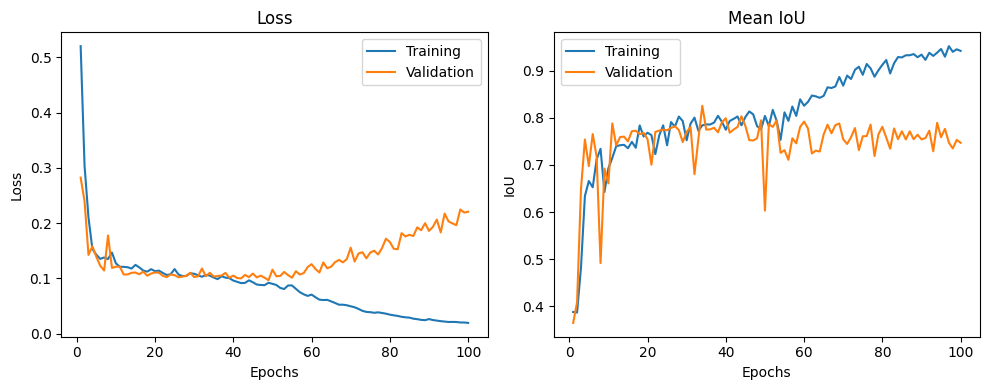

In [ ]:
hist = history.history
epochs = range(1, len(hist['loss']) + 1)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# --- Loss ---
ax[0].plot(epochs, hist['loss'], label='Training')
ax[0].plot(epochs, hist['val_loss'], label='Validation')
ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()

# --- IoU ---
ax[1].plot(epochs, hist['mean_iou'], label='Training')
ax[1].plot(epochs, hist['val_mean_iou'], label='Validation')
ax[1].set_title("Mean IoU")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("IoU")
ax[1].legend()

plt.tight_layout()
plt.show()

**Full prediction**

In this step, we will predict on a new raster image using the trained U-Net model. Inside the `predictRaster()` function, the `processing()` function is used to divide the input raster into patches. After prediction, the patches are reconstructed back into a full raster mosaic with the same size and extent as the original image.

**Key arguments**:  
- `raster_path`: Path to the input raster image (different from the training set or similar).  
- `patch_size`: Patch size used for prediction (must match training).  
- `num_classes`: Number of output classes (same as training).  
- `output_path`: Path to save the predicted raster (optional).  
- `fill_nulls`: If `True`, replaces null values with the value set in `null_value`.  
- `null_value`: Value used to replace missing or infinite values.  
- `normalize`: If `True`, applies the same normalization as during training.  
- `overlap`: Number of pixels to overlap between patches, useful for smoothing predictions.

**Full Prediction**

**1: How to use a saved MODEL?**

If you training and testing in the same session of your Jupyter Notebook, so just run the below code:

In [ ]:
# Step 3: Perform full prediction
prediction = predictRaster(
    model = model,
    raster_path = data_dir + '/'+ 'NRBR_Tile29.tif',
    patch_size = 256,  # Same as used during training
    num_classes = 1,   # Same as used during training
    output_path = data_dir + '/' + 'final_prediction.tif',  # Optional: save result
    fill_nulls = True,
    null_value = 0,
    normalize = True,
    overlap = 0,
)

Processing file: /content/drive/MyDrive/11_deepLearning//NRBR_Tile29.tif
Handling null values...
✅ Normalization applied to X
Running prediction...
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step
Predicted classes: [0 1]
Prediction saved at: /content/drive/MyDrive/11_deepLearning//final_prediction.tif


**2: Using the saved MODEL**

If you just to use a saved MODEL to predict your own data, you just need to load your saved model and use it as follow:

In [ ]:
# load a model
model = tf.keras.models.load_model(data_dir + '/' + 'best_model.keras', compile=False)

# Step 3: Perform full prediction
prediction = predictRaster(
    model = model,
    raster_path = data_dir + '/'+ 'NRBR_Tile29.tif',
    patch_size = 256,  # Same as used during training
    num_classes = 1,   # Same as used during training
    output_path = data_dir + '/' + 'final_prediction.tif',  # Optional: save result
    fill_nulls = True,
    null_value = 0,
    normalize = True,
    overlap = 0,
)

Here we visualize the predicted burned area map alongside the NRBR index raster used as input for the model. This side-by-side comparison allows us to evaluate how the predicted segmentation relates to the original spectral information from the satellite image.

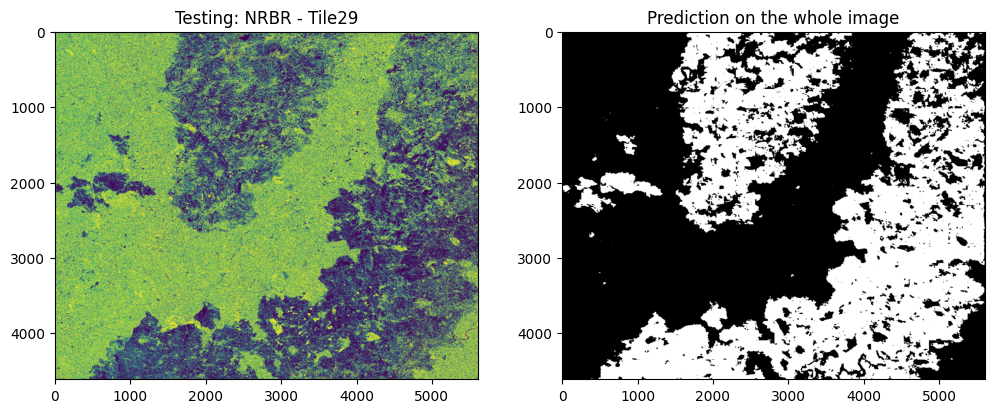

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (12,6))

ax[0].imshow(img_test)
ax[0].set_title('Testing: NRBR - Tile29')
ax[1].imshow(prediction,cmap = reversed_map)
ax[1].set_title('Prediction on the whole image')
plt.show()

## 4.0 Accuracy assessment

In [ ]:
# 2. Load reference labels

# Tile29: Reference data
path_raster_label_test = data_dir + "Label_Tile29.tif"
label_test = rasterio.open(path_raster_label_test).read(1)
label_test[np.isnan(label_test)] = 0

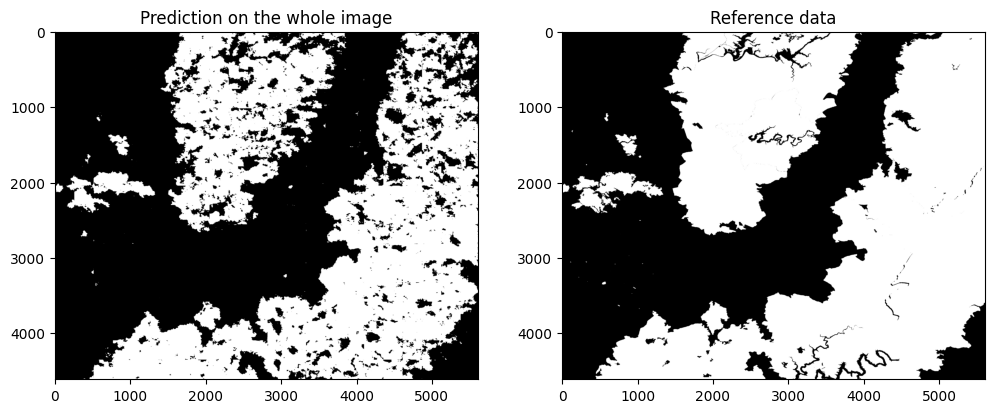

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (12,6))

ax[0].imshow(prediction,cmap = reversed_map)
ax[0].set_title('Prediction on the whole image')
ax[1].imshow(label_test,cmap = reversed_map)
ax[1].set_title('Reference data')
plt.show()

========================== Accuracy Metrics ================================
✅ Evaluation completed. Metrics below are averaged across all classes.
📊 Overall Accuracy (all classes): 0.8839
📊 Precision (weighted): 0.8997
📊 Recall (weighted): 0.8839
📊 F1-score (weighted): 0.8837
📊 IoU (weighted): 0.7917
📊 Dice Coefficient (macro): 0.8839



Confusion matrix:


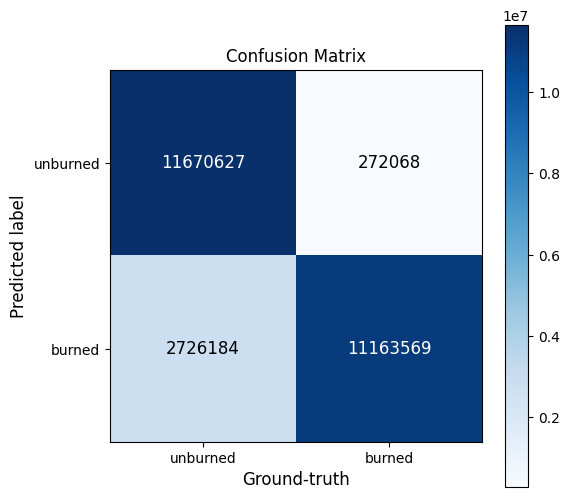

In [ ]:
# 3. Evaluate
results = evaluateSegmentation(y_true_array = label_test,
                               y_pred_array = prediction,
                               num_classes=2,
                               classes=['unburned', 'burned'])